In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [3]:
tr_df = train_df('/kaggle/input/multi-class-knee-osteoporosis-x-ray-dataset/OS Collected Data')
tr_df

,Class Path,Class
0,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
1,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
2,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
3,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
4,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
...,...,...
1942,/kaggle/input/multi-class-knee-osteoporosis-x-...,Normal
1943,/kaggle/input/multi-class-knee-osteoporosis-x-...,Normal
1944,/kaggle/input/multi-class-knee-osteoporosis-x-...,Normal
1945,/kaggle/input/multi-class-knee-osteoporosis-x-...,Normal


In [4]:
train_df, dummies_df = train_test_split(tr_df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(dummies_df, test_size=0.5, random_state=42)

In [5]:
batch_size = 16
img_size = (224,224)

tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))

gen = ImageDataGenerator()


tr_gen = tr_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                 y_col='Class',batch_size=batch_size,
                                 target_size=img_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class',batch_size=batch_size,
                                    target_size=img_size)

ts_gen = gen.flow_from_dataframe(test_df, x_col='Class Path',
                                y_col='Class',batch_size=batch_size,
                                 target_size=img_size,shuffle=False)

Found 1557 validated image filenames belonging to 3 classes.
Found 195 validated image filenames belonging to 3 classes.
Found 195 validated image filenames belonging to 3 classes.


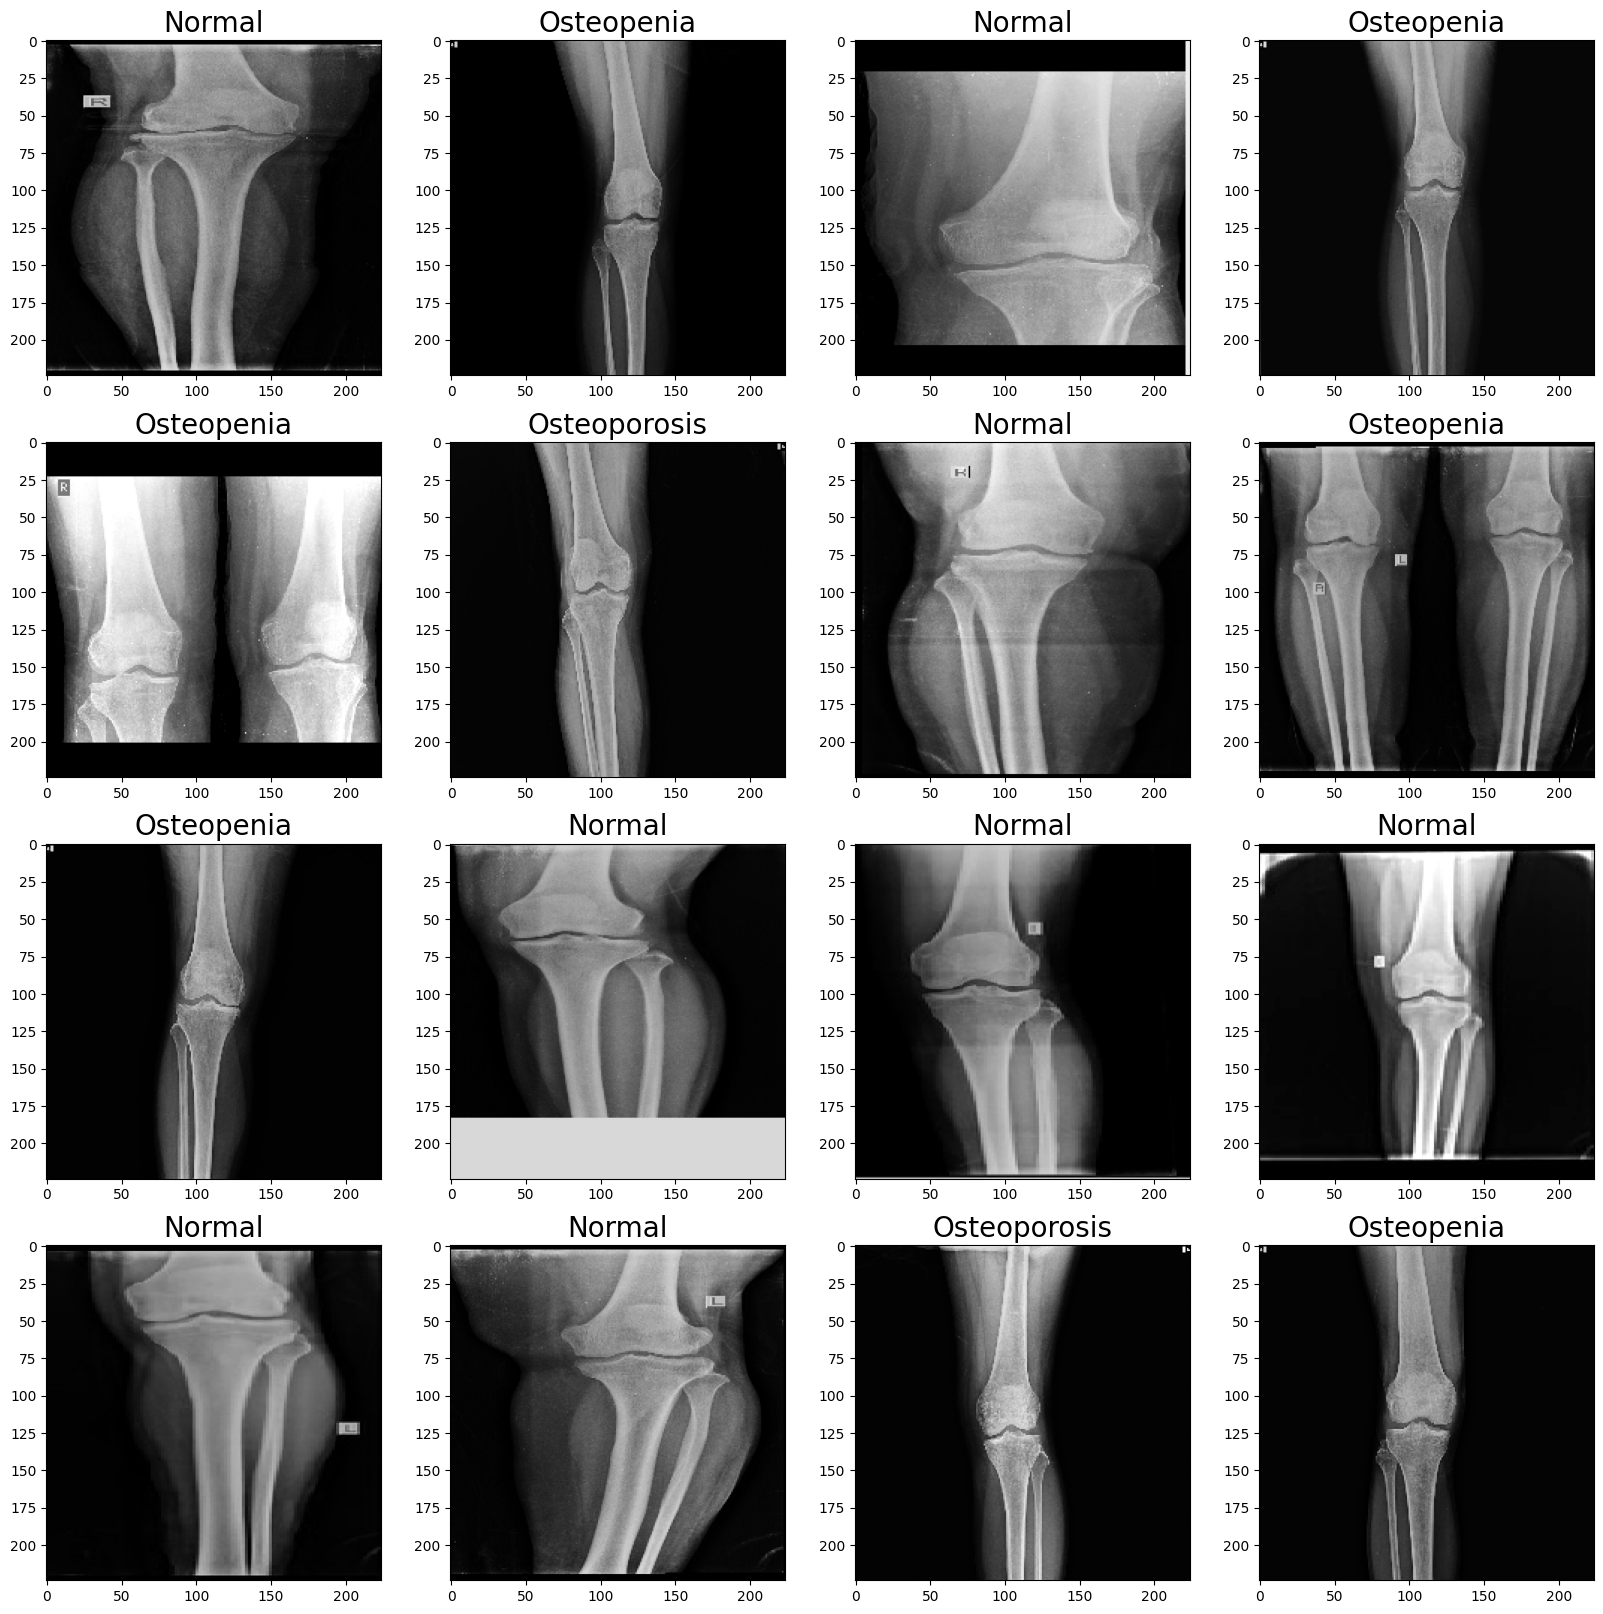

In [6]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='k', fontsize=20)
plt.show()

In [7]:
num_classes = len(classes)
num_classes

3

In [11]:
img_shape=(224,224,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(num_classes, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'binary_crossentropy',
              metrics= ['accuracy'])
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,139 (80.58 MB)

 Trainable params: 21,069,611 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [13]:
history = model.fit(tr_gen,
                 epochs=7,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 96s 628ms/step - accuracy: 0.6359 - loss: 0.5309 - val_accuracy: 0.7949 - val_loss: 0.2917
Epoch 2/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 460ms/step - accuracy: 0.8325 - loss: 0.2697 - val_accuracy: 0.8513 - val_loss: 0.3140
Epoch 3/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 48s 483ms/step - accuracy: 0.8617 - loss: 0.2148 - val_accuracy: 0.8974 - val_loss: 0.1919
Epoch 4/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - accuracy: 0.9098 - loss: 0.1453 - val_accuracy: 0.8769 - val_loss: 0.1999
Epoch 5/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.9322 - loss: 0.1138 - val_accuracy: 0.9128 - val_loss: 0.2135
Epoch 6/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 453ms/step - accuracy: 0.9306 - loss: 0.1024 - val_accuracy: 0.8667 - val_loss: 0.2683
Epoch 7/7
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - accuracy: 0.9389 - loss: 0.0959 - val_accuracy: 0.8974 - val_loss: 0.1937


In [14]:
model.evaluate(ts_gen, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 549ms/step - accuracy: 0.9022 - loss: 0.2899


[0.2884511649608612, 0.892307698726654]

In [15]:
model.save("knee_Model.h5")

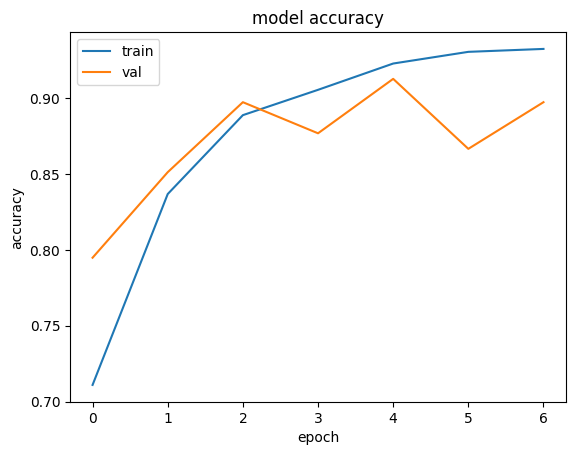

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

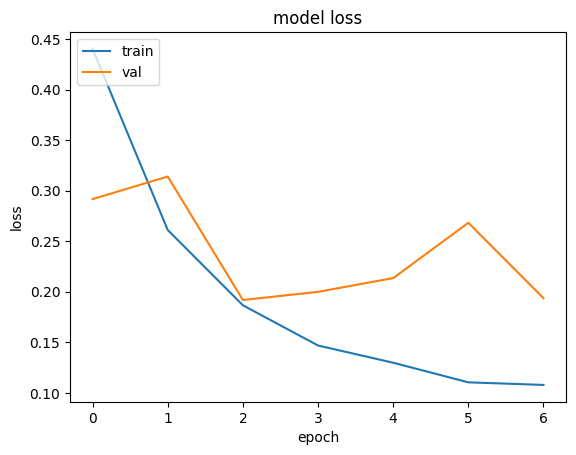

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
pred = model.predict(ts_gen)
pred = np.argmax(pred, axis=1)

labels = (tr_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_df['Class']
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.92      0.96      0.94        70
  Osteopenia       0.88      0.79      0.84        48
Osteoporosis       0.87      0.90      0.88        77

    accuracy                           0.89       195
   macro avg       0.89      0.88      0.89       195
weighted avg       0.89      0.89      0.89       195

Accuracy of the Model: 89.2%


In [22]:
classes=list(tr_gen.class_indices.keys())
print (classes)

['Normal', 'Osteopenia', 'Osteoporosis']


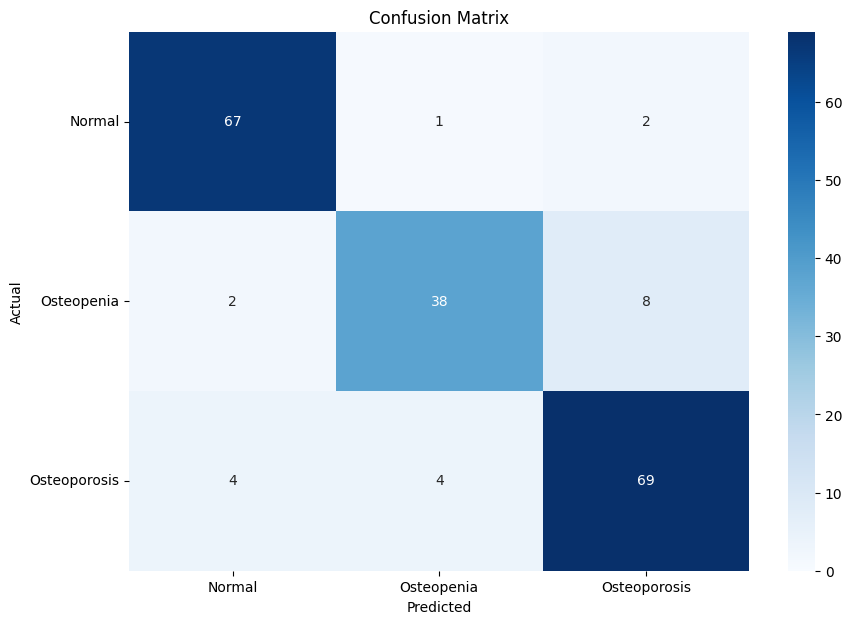

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_df['Class'].values
cm = confusion_matrix(y_true, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

num_classes = len(classes)

plt.xticks(ticks=[i + 0.5 for i in range(num_classes)], labels=classes, rotation=0)
plt.yticks(ticks=[i + 0.5 for i in range(num_classes)], labels=classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()